<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Catboost" data-toc-modified-id="Catboost-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть, клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет определять токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не менее 0.75. 

## Подготовка данных

In [1]:
!pip install catboost==1.1.1
!pip install xgboost==1.7.5
!pip install lightgbm==3.3.5
!pip install scikit-learn==1.2.2

In [2]:
# Импортируем необходимые библиотеки
import os
import numpy as np
import pandas as pd
import math
import torch
import re
import time
import transformers as ppb # pytorch transformers
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import nltk
import string
from transformers import AutoModel, AutoTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV, 
                                     cross_val_score,
                                     RandomizedSearchCV
                                    )
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             classification_report)
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from tqdm import notebook, tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Создать локальную директорию datasets, если она отсутствует
try:
    os.makedirs('datasets')
except IOError:
    pass

# Загрузка сырых данных
local_data = 'datasets/toxic_comments.csv'
try:
    df = pd.read_csv(local_data)
    print('dataset loaded from cache')
except IOError:
    print('downloading dataset...')
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
    df = df.drop(df.columns[0], axis=1)
    df.to_csv(local_data, index=False)
    print('dataset downloaded and saved to cache')

# Посмотрим основную информацию о датафрейме
print('Размер датафрейма:', df.shape)
print('Пропуски:', df.isna().sum())
print('Дубликаты:', df.duplicated().sum())
df.sample(5)

dataset loaded from cache
Размер датафрейма: (159292, 2)
Пропуски: text     0
toxic    0
dtype: int64
Дубликаты: 0


,text,toxic
61925,"""\n\n The POV statements in question are your ...",0
102558,gen xer here\n-\nto me everyone is gonna have ...,0
115262,And I'm removing: it is accessible from the of...,0
126426,December 2009 ==\n\nPlease provide the actual ...,0
60967,"""\n\n I've been banned (permanently?) from Wik...",0


**Создадим функцию для предварительной обработки датафрейма.**

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

def remove_ip_addresses(text):
    # Define a regular expression for matching IP addresses
    ip_regex = r'\b(?:\d{1,3}\.){3}\d{1,3}\b'
    # Replace all occurrences of IP addresses with an empty string
    return re.sub(ip_regex, '', text)

def preprocess_text(df):
    """
    The function preprocesses all textual columns in the DataFrame:
    - removes stop words
    - removes newline characters
    - removes punctuation
    - converts text to lower case
    """
    # Initialize the set of stop words
    stop_words = set(stopwords.words('english'))
    
    # Iterate over all columns in the DataFrame
    for col in df.columns:
        # Only consider string columns
        if df[col].dtype == 'object':
            
            # Apply preprocessing steps to each cell in the column
            df[col] = df[col].apply(lambda x: 
                                    remove_ip_addresses(
                                    ' '.join([
                                        word for word in word_tokenize(str(x).lower()) 
                                        if word not in stop_words and word not in string.punctuation and word != '\n'
                                            ])
                                       )
                                   )
                # Use tqdm to track progress
            df[col] = tqdm(df[col], desc=f"Processing {col}")
    return df

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Сделаем предобработку текста в датафрейме
df = preprocess_text(df.copy())

Processing text: 100%|██████████| 159292/159292 [00:00<00:00, 1573103.48it/s]


<AxesSubplot: title={'center': 'Баланс классов'}, ylabel='toxic'>

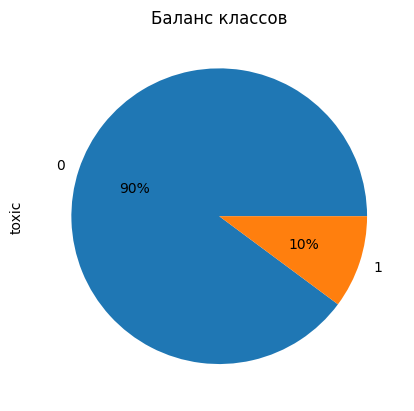

In [6]:
# Рассмотрим сбалансированность классов
df['toxic'].value_counts(normalize=True).plot(kind='pie', autopct='%1.0f%%', title='Баланс классов')

**В данных присутствует сильный дисбаланс классов. Устраним его после создания эмбеддингов и разбиения на выборки.**

**Создадим эмбеддинги с помощью предобученной модели BERT.**

In [7]:
# Необходимо раскоментировать строки с нужной моделью BERT
# Использование модели BERT
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Использование модели DistilBERT
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Загрузка предобученной модели/токенизатора для BERT или DistilBERT
# tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# model = model_class.from_pretrained(pretrained_weights)

# Использование модели toxic-BERT
model_name = "unitary/toxic-bert" 
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
try:
    # try to load from preprocessed ndarray file
    padded = np.load('datasets/padded.npy')
    print('Padded array loaded from cache.')
except IOError:
    # Сделаем токенизацию
    print('Making tokenization...')
    tokenized = df['text'].apply((lambda x: tokenizer.encode(x[:512], add_special_tokens=True)))
    
    # Найдём максимальную длину списка
    max_len = len(max(tokenized, key=len))

    # Приведем весь список к одинаковой длине
    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
    
    # Сохраним массив в кеш
    np.save('datasets/padded.npy', padded)
    print('padded array saved to cache.')
    
attention_mask = np.where(padded != 0, 1, 0)

Padded array loaded from cache.


In [9]:
def timer(func):
    """Timer decorator"""
    def wrapper(*args, **kwargs):
        start = datetime.now()
        result = func(*args, **kwargs)
        total_time = (datetime.now() - start).total_seconds()
        print(f'Total timelimit: {total_time}')
        return result
    return wrapper

@timer
def make_features(model, padded, attention_mask, batch_size: int, use_cache:bool = True, mmap_mode:bool = False) -> np.ndarray:
    """Function makes features from padded array

    Args:
        model (torch model): pretrained torch model
        padded (ndarry): padded array
        attention_mask (ndarray): attention mask
        batch_size (int): batch size for prediction
        use_cache (bool, optional): use cahce for save/load file. Defaults to True.
        mmap_mode (bool, optional): Read or load features file from cache. Defaults to False.

    Returns:
        np.ndarray: features array
    """
    if use_cache:
        try:
            # try to load embeddings from ndarray file
            if mmap_mode:
                features = np.load('datasets/features.npy', mmap_mode='r')
            else:
                features = np.load('datasets/features.npy')
            print('Features loaded from cache.')
            return features
        except IOError:
            pass      
            
    cuda_available = torch.cuda.is_available()
    if cuda_available:
        # Select first CUDA device
        device = torch.device("cuda:0")
        print("Используется устройство:", torch.cuda.get_device_name(device))

        # move model to CUDA device
        model = model.to(device)

    embeddings = []
    loop_range = range(math.ceil(padded.shape[0] / batch_size))
    timer_arr = [] # array for calculate execution time
    for i in loop_range:
        timer = datetime.now()
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        if cuda_available:
            # move tensors to CUDA device
            batch = batch.to(device)
            attention_mask_batch = attention_mask_batch.to(device)
            
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
            
        # .cpu() method needs if CUDA device used
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        
        timer_arr.append((datetime.now() - timer).total_seconds())
        
        # print statistic
        if i%100 == 0:
            mean_iteration_time = np.array(timer_arr).mean()
            timeleft = int((len(loop_range) - i) * mean_iteration_time)
            print(f'{i}/{len(loop_range)} timeleft {timeleft} sec.')
    
    features = np.concatenate(embeddings)
    
    if use_cache:
        # Save array to cache
        np.save('datasets/features.npy', features)
        print('features array saved to cache.')
    
    return features
    

In [10]:
# Создадим эмбеддинги
features = make_features(model, padded, attention_mask, 128)

Features loaded from cache.
Total timelimit: 2.3021


In [11]:
# Разобьём данные на выборки c фичами от модели BERT
X_train, X_test, y_train, y_test = train_test_split(
    features, df['toxic'], test_size=0.2, stratify=df['toxic'])
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.11, stratify=y_train)

print('Размеры выборок:', X_train.shape, X_valid.shape, X_test.shape)

Размеры выборок: (113415, 768) (14018, 768) (31859, 768)


In [12]:
# Undersampling для преобладающего класса
X_train_majority = X_train[y_train==0]
X_train_minority = X_train[y_train==1]
X_train_majority_downsampled = resample(X_train_majority, n_samples=len(X_train_minority), random_state=42)
X_train_downsampled = np.concatenate((X_train_majority_downsampled, X_train_minority), axis=0)
y_train_downsampled = np.concatenate((np.zeros(len(X_train_majority_downsampled)), np.ones(len(X_train_minority))), axis=0)

# Вычисление весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

Длина оригинальной выборки 113415
Длина undersampled выборки 23050


<AxesSubplot: title={'center': 'Баланс классов'}>

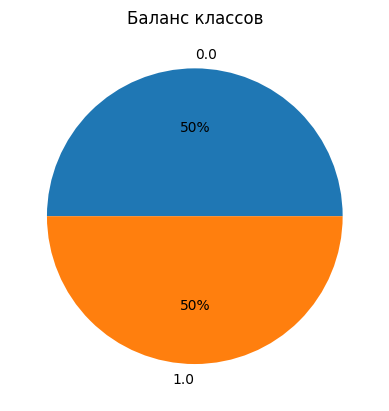

In [13]:
# Проверим сбалансированность классов
print('Длина оригинальной выборки', len(y_train))
print('Длина undersampled выборки', len(y_train_downsampled))
pd.Series(y_train_downsampled).value_counts(normalize=True).plot(kind='pie', autopct='%1.0f%%', title='Баланс классов')

**Выводы:**

В первой части работы мы загрузили данные, провели их предобработку, удалив стоп-слова, айпи-адреса, пунктуацию и спецсимволы. После чего были созданы эмбеддинги моделью toxic-BERT, проведено разбиение на три выборки и устранён дисбаланс классов для применения моделей, неспособных бороться с ним самостоятельно. Теперь данные готовы для обучения моделей и составления прогнозов токсичности комментариев.

## Обучение

In [14]:
# Функция для расчета времени выполнения ячейки
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return ("{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

In [15]:
# Создадим список для сохранения результатов моделей
results = {}

### Catboost

**Здесь и далее во всех моделях скрыт перебор параметров для ускорения работы ноутбука. Также, была протестирована работа моделей на downsampled выборке и оригинальной, результаты всех моделей были значительно лучше на оригинальной выборке, потому оставлены только они.**

In [16]:
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [17]:
# # RandomizedSearchCV
# cb_model = cb.CatBoostClassifier(eval_metric='F1')
# parameters = {'depth'         : [6, 8, 10, 12],
#               'learning_rate' : [0.01, 0.025, 0.1],
#               'iterations'    : [500, 1000]
#              }
# random = RandomizedSearchCV(cb_model, param_distributions=parameters, cv=3, n_jobs=-1, scoring='f1', verbose=10)
# random.fit(X_train, y_train)

In [18]:
# Сохраним время начала выполнения кода
start = time.time()

# Обучим модель
cb_model = cb.CatBoostClassifier(
         task_type='GPU',
#         iterations=1000,
         eval_metric='F1',
#         class_weights=class_weights,
#         learning_rate=0.025
            )
cb_model.fit(X_train, y_train, verbose=100)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
cb_fit_time = exec_time(start, end)

Learning rate set to 0.025988
0:	learn: 0.9304443	total: 15.5ms	remaining: 15.5s
100:	learn: 0.9396043	total: 1.49s	remaining: 13.3s
200:	learn: 0.9434061	total: 2.98s	remaining: 11.9s
300:	learn: 0.9470051	total: 4.45s	remaining: 10.3s
400:	learn: 0.9504699	total: 6.04s	remaining: 9.02s
500:	learn: 0.9537130	total: 8.24s	remaining: 8.21s
600:	learn: 0.9558830	total: 9.7s	remaining: 6.44s
700:	learn: 0.9588657	total: 11.1s	remaining: 4.75s
800:	learn: 0.9614106	total: 12.6s	remaining: 3.14s
900:	learn: 0.9638449	total: 14.1s	remaining: 1.55s
999:	learn: 0.9662803	total: 15.6s	remaining: 0us


In [19]:
# Сохраним время начала выполнения кода
start = time.time()

# Получим предсказания модели
cb_predictions = cb_model.predict(X_valid)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
cb_pred_time = exec_time(start, end)

In [20]:
# print('Catboost F1:',f1_score(y_valid,cb_predictions))
# print('Catboost fitting time:', cb_fit_time)
# print('Catboost prediction time:', cb_pred_time)
# print(classification_report(y_valid, cb_predictions))
results['Catboost'] = [f1_score(y_valid,cb_predictions),cb_fit_time,cb_pred_time]

**Здесь и далее, для каждой модели, вывод результата модели скрыт, а результаты вывода сохранены в словарь для удобного отображения всех результатов в одном месте.**

### LightGBM

In [21]:
# Сохраним время начала выполнения кода
start = time.time()

# Обучим модель
lgb_model = lgb.LGBMClassifier(
#         iterations=1000,
#         eval_metric='F1',
#         class_weights=class_weights,
#         learning_rate=0.025
            )
lgb_model.fit(X_train, y_train)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
lgb_fit_time = exec_time(start, end)

In [22]:
# Сохраним время начала выполнения кода
start = time.time()

# Получим предсказания модели
lgb_predictions = lgb_model.predict(X_valid)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
lgb_pred_time = exec_time(start, end)

In [23]:
# print('LightGBM F1:',f1_score(y_valid,lgb_predictions))
# print('LightGBM fitting time:', lgb_fit_time)
# print('LightGBM prediction time:', lgb_pred_time)
# print(classification_report(y_valid, lgb_predictions))
results['LightGBM'] = [f1_score(y_valid,lgb_predictions),lgb_fit_time,lgb_pred_time]

### XGBoost

In [24]:
# # RandomizedSearchCV
# xgb_model = xgb.XGBClassifier(tree_method="gpu_hist")
# parameters = {'max_depth'         : [6, 8, 10],
#               'learning_rate' : [0.05, 0.12, 0.2],
#               "n_estimators": [300, 600, 900],
#              }
# random = RandomizedSearchCV(xgb_model, param_distributions=parameters, cv=3, n_jobs=-1, scoring='f1',verbose=10)
# random.fit(X_train, y_train)

In [25]:
# Сохраним время начала выполнения кода
start = time.time()

# Обучим модель
xgb_model = xgb.XGBClassifier(
        tree_method='gpu_hist',
#         max_depth=6,
#       eval_metric='f1',
#         n_estimators=900,
#         learning_rate=0.05
            )
xgb_model.fit(X_train, y_train)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
xgb_fit_time = exec_time(start, end)

In [26]:
# Сохраним время начала выполнения кода
start = time.time()

# Получим предсказания модели
xgb_predictions = xgb_model.predict(X_valid)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
xgb_pred_time = exec_time(start, end)

In [27]:
# print('XGBoost F1:',f1_score(y_valid,xgb_predictions))
# print('XGBoost fitting time:', xgb_fit_time)
# print('XGBoost prediction time:', xgb_pred_time)
# print(classification_report(y_valid, xgb_predictions))
results['XGBoost'] = [f1_score(y_valid,xgb_predictions),xgb_fit_time,xgb_pred_time]

### Логистическая регрессия

In [28]:
# Сохраним время начала выполнения кода
start = time.time()

# Обучим и протестируем модель линейной регрессии
lr_model = LogisticRegression(max_iter=2000)
lr_model.fit(X_train, y_train)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
lr_fit_time = exec_time(start, end)

In [29]:
# Сохраним время начала выполнения кода
start = time.time()

# Получим предсказания модели
lr_predictions = lr_model.predict(X_valid)

# Сохраним время окончания выполнения кода и время выполнения ячейки
end = time.time()
lr_pred_time = exec_time(start, end)

In [30]:
# print('LogisticRegression F1:',f1_score(y_valid,lr_predictions))
# print('LogisticRegression fitting time:', lr_fit_time)
# print('LogisticRegression prediction time:', lr_pred_time)
# print(classification_report(y_valid, lr_predictions))
results['LogisticRegression'] = [f1_score(y_valid,lr_predictions),lr_fit_time,lr_pred_time]

## Выводы

**Выведем на экран метрики всех обученных моделей.**

In [31]:
for elem in results:
    print(elem, 'RMSE:', results[elem][0])
    print(elem, 'fitting time:', results[elem][1])
    print(elem, 'prediction time:', results[elem][2])
    print('- ' * 15)

Catboost RMSE: 0.9343168247277837
Catboost fitting time: 00:00:29
Catboost prediction time: 00:00:01
- - - - - - - - - - - - - - - 
LightGBM RMSE: 0.9306582189369941
LightGBM fitting time: 00:01:40
LightGBM prediction time: 00:00:00
- - - - - - - - - - - - - - - 
XGBoost RMSE: 0.9338028169014085
XGBoost fitting time: 00:00:19
XGBoost prediction time: 00:00:00
- - - - - - - - - - - - - - - 
LogisticRegression RMSE: 0.9305114638447971
LogisticRegression fitting time: 00:02:10
LogisticRegression prediction time: 00:00:00
- - - - - - - - - - - - - - - 


**Полученные метрики говорят о том, что все четыре модели показали очень близкие результаты как по метрике F1, так и по времени обучения и предсказания. Далее проведём тестирование модели Catboost с наилучшей метрикой F1 на тестовых данных.**

In [32]:
# Получим предсказания по тестовой выборке
cb_test_predictions = cb_model.predict(X_test)

# Выведем на экран итоговую метрику
print('Catboost F1 на тестовой выборке:',f1_score(y_test,cb_test_predictions))

Catboost F1 на тестовой выборке: 0.9370912488321396


In [33]:
# Создаем экземпляр дамми модели
dummy_model = DummyClassifier(strategy='most_frequent')

# Обучаем дамми модель на тренировочных данных
dummy_model.fit(X_train, y_train)

# Получаем предсказания дамми модели на тестовых данных
dummy_pred = dummy_model.predict(X_test)

# Выведем на экран итоговую метрику
print('Dummy F1 на тестовой выборке:',f1_score(y_test,dummy_pred))

Dummy F1 на тестовой выборке: 0.0


**ИТОГОВЫЙ ВЫВОД:**

В ходе работы мы подготовили данные, после чего на их основании построили эмбеддинги предобученной моделью Toxic_BERT. После чего были обучены четыре модели для предсказания токсичности комментариев, показавшие очень близкие результаты как по метрике F1, так и по времени обучения и предсказания. Из моделей для финального тестирования была выбрана модель Catboost, имеющая наивысшую метрику F1 и хорошее время обучения. Тестирование на тестовой выборке показало стабильность модели, итоговая метрика F1 = 0.937. На основании исследования мы можем рекомендовать связку из предобученной модели Toxic-BERT и модели классификатора Catboost для оценки токсичности комментариев.